### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 
### Radmehr Ghassabtabarshiadeh

Part A

A/B testing to determine whether SHVR or ZIC traders perform better using BSE market sessions simulation to est the null hypothesis that there is no signifacnt difference between the two traders and the alternative hypothesis of there being a signifacnt difference between the two traders with the significance value set to 0.05. A market session will run with the specification mentioned on the brief with start time and end time are set to 0 and 600 respectively. After the simulation are complete, two data frames are created, one with everything the "dump_avgbals" creates and another only taking in the accumilated average profit of each trader. To test the hypothesis, t-test was used, this test allows to see whether the observed differences are statistically significant. Some helper functions are below to help do what was described. The functions "make_df" and "collect_avg_profit" are helper functions for "run_market_sim" which create a dataframe and grab the average profit for the two traders after each market session. The collected averages, are plotted to understand their distribution using "kdeplot" and to understand whether further normalisation is rquired or not. After determining whether the data is parametric or not, either a t-test or Mann-Whitney-U test will be applied to compare the two traders.

In [1]:
# Some code...
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
from scipy import stats
import pandas as pd
import seaborn as sns 

from BSE import market_session

def make_df(path: str):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2', 'err']
    df_profit = df[['avg profit1', 'avg profit2']]
    df_profit.columns = ['SHVR', 'ZIC']
    return df, df_profit

def collect_avg_profit(df):
    _zic = df['ZIC'][len(df)-1]
    _shvr = df['SHVR'][len(df)-1]
    return _zic, _shvr

def trader_specs_two(R, n):
    SHVR_num = (n*R)//100
    zic_num = ((100-R)*n)//100
    buyer_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    seller_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
    return trader_specs

def run_market_sim(trial_id, no_sessions, R, n, supply_range, demand_range, start_time, end_time, path):
    trader_specs = trader_specs_two(R, n)
    total_avg_zic = []
    total_avg_shvr = []
    
    for _ in range(no_sessions):
        supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
        demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
        order_interval = 60
        order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                    'interval': order_interval, 'timemode': 'periodic'}
        dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}

        verbose = False
        market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
        _, df_profit = make_df(path)
        _zic, _shvr = collect_avg_profit(df_profit)
        total_avg_shvr.append(_shvr)
        total_avg_zic.append(_zic)
    
    return total_avg_shvr, total_avg_zic

In [2]:
n500mean_shvr, n500mean_zic = run_market_sim(trial_id="n500", no_sessions=500, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n500_avg_balance.csv')
n50mean_shvr, n50mean_zic = run_market_sim(trial_id="n50", no_sessions=50, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n50_avg_balance.csv')

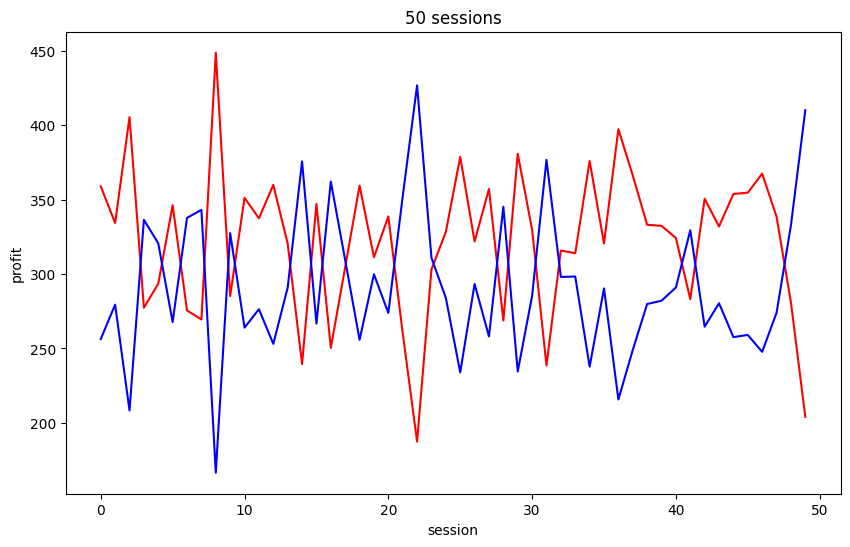

Text(0, 0.5, 'profit')

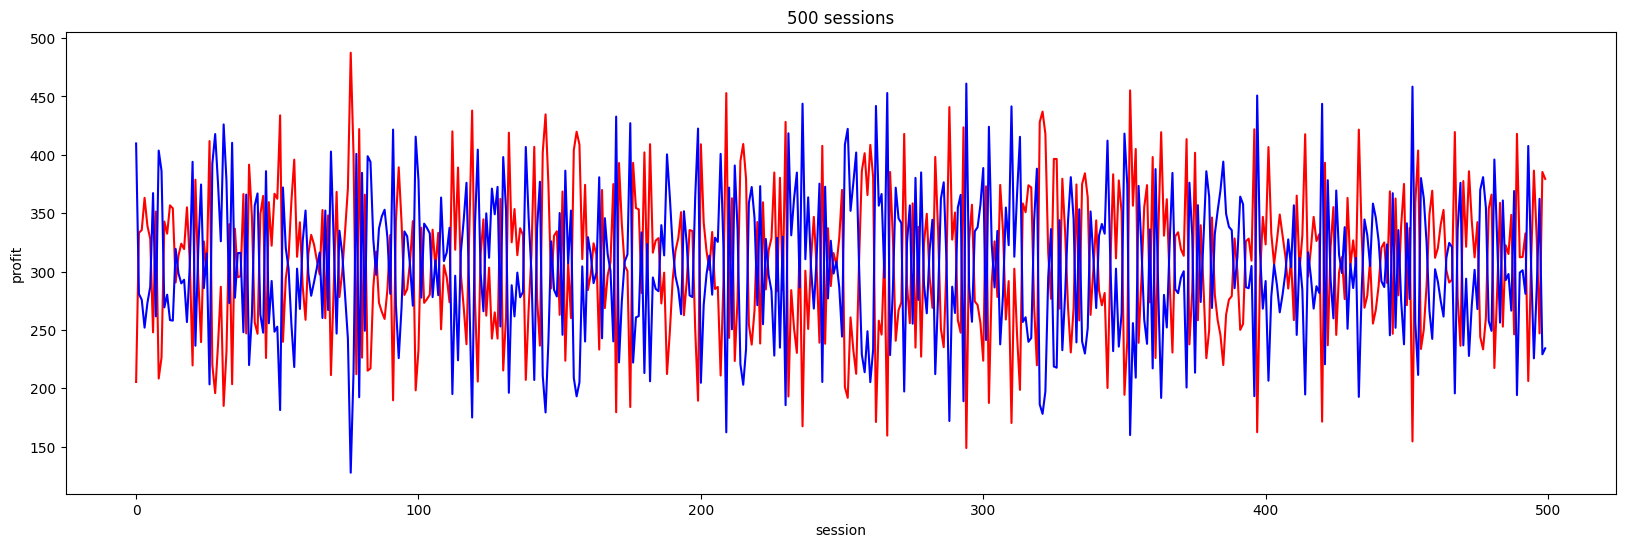

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(n50mean_zic, 'r', n50mean_shvr, 'b')
plt.title('50 sessions')
plt.xlabel('session')
plt.ylabel('profit')
plt.show()
plt.figure(figsize=(20, 6))
plt.plot(n500mean_zic, 'r', n500mean_shvr, 'b')
plt.title('500 sessions')
plt.xlabel('session')
plt.ylabel('profit')

The plots above showcase what was the average profit a trader made at the end of a session, zic traders being red and shvr traders being blue. It is observed that the profitablity is shared roughly equally between the two traders. So the expected results from the statistical test would be to conclude that we do not have sufficient evidence to reject the null hypothesis. That mean, there is no significant difference between the two traders when it comes to average profit in the market.

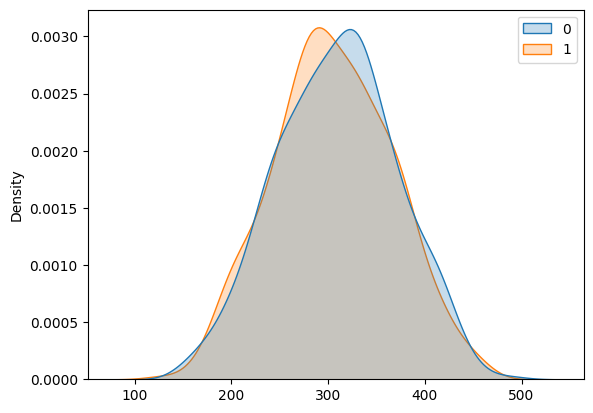

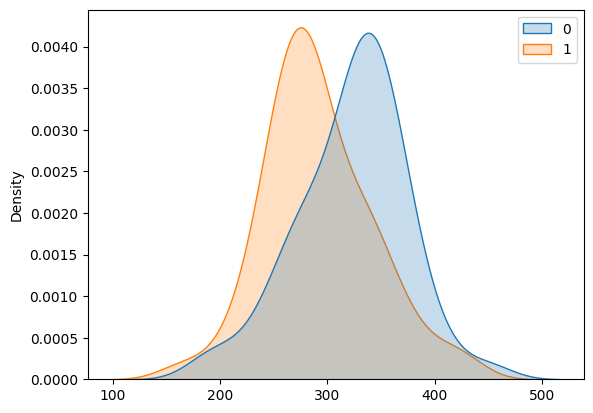

0.279983252286911 0.3133131265640259 0.4098547101020813 0.33442187309265137


In [35]:
plot_500 = sns.kdeplot([n500mean_zic, n500mean_shvr], fill=True)
plt.show()
plot_50 = sns.kdeplot([n50mean_zic, n50mean_shvr], fill=True)
plt.show()
_, pvalue50_shvr = stats.shapiro(n500mean_shvr)
_, pvalue500_shvr = stats.shapiro(n50mean_shvr)
_, pvalue500_zic = stats.shapiro(n500mean_zic)
_, pvalue50_zic = stats.shapiro(n50mean_zic)
print(pvalue50_shvr, pvalue500_zic, pvalue50_zic, pvalue500_shvr)

KDE plot was used to see the distribution of the data for each session. As the output demonstrates, both data sets are following a normal distribution therefore, no further normalisation is required and a t-test can be used. This is further reinforced when Shapiro-Wilk test is applied, as for each average profit for each trader under different sessions, the p value is higher than the threshold of 0.05.

In [31]:
_, p_val50 = stats.ttest_ind(n50mean_zic, n50mean_shvr)
print(p_val50, '50 sessions')
_, p_val500 = stats.ttest_ind(n500mean_zic, n500mean_shvr)
print(p_val500, '500 sessions')

0.0028119577056339227 50 sessions
0.3496431146369229 500 sessions


The P value for when ther are 50 market sessions is less than the threshold of 0.05 suggesting that there is a significant differences between the traders, in favor of shvr. However, the p value for the 500 sessions gives a value above the threshold, suggesting that there is no significant difference between the two traders. 

In conclusion, with the sessions simulated and the data collected, initially there seems to be an advantage for shvr traders but when the number of sessions increase, there is no evidence of significant difference between the two traders, therefore the performance of the two traders are rougly equal.

PART B

For this part, the ratio of the market agents are manipulated to the brief's specification. Code cell below, modifies the previously used code to accomedate these changes by collecting and returning the resaults in an two dimensional array. Within each resault, there are two data sets, the first being mean profit of shvr while the second being zic traders. For each pair of data, 9 in this case, they will be tested to see whether they are normaly distributed using Shapiro-Wilk and then appropriate hypothesis testing of either t-test or Mann-Whitney-U test is used based on the shapiro test's return.

In [7]:
def R_market_run(R, no_sessions, n, supply_range, demand_range, start_time, end_time):
    res = []
    tmp = "n" + str(no_sessions) + "_"
    for r in R:
        trial_id = tmp + str(r)
        path = str(trial_id) + "_avg_balance.csv"
        res.append(run_market_sim(trial_id, no_sessions, r, n, supply_range, demand_range, start_time, end_time, path))

    return res

In [8]:
R = [10, 20, 30, 40, 50, 60, 70, 80, 90]

res50 = R_market_run(R, 50, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60) #9 arr corresponding to each ratio, res[n][0]=shvr, [n][1]=zic each 50 long                                                                                                             #res[n][0] = shvr, res[n][1] = zic
res500 = R_market_run(R, 500, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60) #same as above but 500 long

In [46]:
def collect_pvals_norm(marketoutput: list):
    res = []
    for i in range(len(marketoutput)):
        _, p_shvr = stats.shapiro(marketoutput[i][0])
        _, p_zic = stats.shapiro(marketoutput[i][1])
        p_res_50 = [p_shvr, p_zic]
        res.append(p_res_50)
    return res

p_vals_50 = collect_pvals_norm(res50)
p_vals_500 = collect_pvals_norm(res500)

def A_B_test(p_val: list, data_: list, a: float = 0.05):
    res = []

    for i in range(len(p_val)):
        if p_val[i][0] < a or p_val[i][1] < a:
            _, pval = stats.mannwhitneyu(data_[i][0], data_[i][1])
            res.append(pval)
        elif p_val[i][0] > a and p_val[i][1] > a:
            _, pval = stats.ttest_ind(data_[i][0], data_[i][1])
            res.append(pval)
    
    return res

p_res50 = A_B_test(p_vals_50, res50)
p_res500 = A_B_test(p_vals_500, res500)

print(p_vals_50)
print(p_vals_500)
print(p_res50)
print(p_res500)

9
[[0.016594307497143745, 0.0201741810888052], [0.4367845058441162, 0.4209964871406555], [0.5747305154800415, 0.6041735410690308], [0.8158426284790039, 0.805486261844635], [0.10993264615535736, 0.11540063470602036], [0.33893731236457825, 0.35149431228637695], [0.6698495149612427, 0.6587966680526733], [0.7628936767578125, 0.7636106610298157], [0.1365228146314621, 0.13526582717895508]]
[[1.3813897803416353e-09, 2.5308573015081492e-09], [0.07149757444858551, 0.06790029257535934], [0.244542196393013, 0.3021027147769928], [0.11157418042421341, 0.11966851353645325], [0.4511035680770874, 0.5057697892189026], [0.7059348821640015, 0.7395371794700623], [0.04783662408590317, 0.04497436434030533], [0.3465295433998108, 0.3507861793041229], [1.5679697185078112e-07, 1.2775450386470766e-07]]
[0.7174068596958636, 0.639629564504364, 0.9092042984103949, 0.866372327194473, 0.9531222813552045, 0.13945757334262596, 0.5307458519844406, 0.23670165428072817, 0.7464558873441006]
[3.1466632335766193e-05, 4.05658

In [10]:
def anova_test(df):
    shvr_avg = df['SHVR']
    gvwy_avg = df['GVWY']
    zic_avg = df['ZIC']
    zip_avg = df['ZIP']
    _, p = stats.f_oneway(shvr_avg, gvwy_avg, zic_avg, zip_avg)
    return p

def collect_mean_4(df):
    mean_zic = df['ZIC'][len(df)-1]
    mean_shvr = df['SHVR'][len(df)-1]
    mean_GVWY = df['GVWY'][len(df)-1]
    mean_zip = df['ZIP'][len(df)-1]
    return mean_shvr, mean_GVWY, mean_zic, mean_zip

def df_four(path):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2',
                   'trader3', 'total profit3', 'no. 3', 'avg profit3', 'trader4', 'total profit4', 'no. 4', 'avg profit4', 'err']
    df_profit = df[['avg profit1', 'avg profit2', 'avg profit3', 'avg profit4']]
    df_profit.columns = ['GVWY', 'SHVR', 'ZIC', 'ZIP']
    return df, df_profit    

def four_trader_specs(t: list, n: int):
    res = []
    for i in range(len(t)):
        t = np.roll(t, i)
        tmp = []
        for x in t:
            tmp.append(int(x))
        t = tmp
        shvr_num = (t[0]*n)/100
        gvwy_num = (t[1]*n)/100
        zic_num = (t[2]*n)/100
        zip_num = (t[3]*n)/100
        buyer_specs = [('SHVR', int(shvr_num)), ('GVWY', int(gvwy_num)), ('ZIC', int(zic_num)), ('ZIP', int(zip_num))]
        seller_specs = [('SHVR', int(shvr_num)), ('GVWY', int(gvwy_num)), ('ZIC', int(zic_num)), ('ZIP', int(zip_num))]
        trader_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
        res.append(trader_specs)
    return res

def run_market_sim_four(trial_id, no_sessions, t, n, supply_range, demand_range, start_time, end_time):

    if t == [25, 25, 25, 25]:
        mean_shvr_t = []
        mean_GVWY_t = []
        mean_zic_t = []
        mean_zip_t = []
        seller_spec = [('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
        buyer_spec = [('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
        trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
        path = str(trial_id) + "_avg_balance.csv"
        for _ in range(no_sessions):
            supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
            demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
            order_interval = 60
            order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
            dump_flags = {'dump_blotters': True, 'dump_lobs': True, 'dump_strats': True,
                            'dump_avgbals': True, 'dump_tape': True}
            verbose = False
            market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
            _, df_profit = df_four(path)
            mean_shvr, mean_GVWY, mean_zic, mean_zip = collect_mean_4(df_profit)
            mean_shvr_t.append(mean_shvr)
            mean_GVWY_t.append(mean_GVWY)
            mean_zic_t.append(mean_zic)
            mean_zip_t.append(mean_zip)
    else:
        trader_specs = four_trader_specs(t, n)

        for i, ts in enumerate(trader_specs):
            mean_shvr_t = []
            mean_GVWY_t = []
            mean_zic_t = []
            mean_zip_t = []
            trial_id = trial_id + str(i) + "_shift"
            path = str(trial_id) + "_avg_balance.csv"
            for _ in range(no_sessions):
                supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
                demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
                order_interval = 60
                order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
                dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}
                verbose = False
                market_session(trial_id, start_time, end_time, ts, order_sched, dump_flags, verbose)
                _, df_profit = df_four(path)
                mean_shvr, mean_GVWY, mean_zic, mean_zip = collect_mean_4(df_profit)
                mean_shvr_t.append(mean_shvr)
                mean_GVWY_t.append(mean_GVWY)
                mean_zic_t.append(mean_zic)
                mean_zip_t.append(mean_zip)

            
    return mean_shvr_t, mean_GVWY_t, mean_zic_t, mean_zip_t

In [11]:
t = [25, 25, 25, 25]
t1 = [40, 20, 20, 20]
t2 = [10, 30, 30, 30]
t3 = [70, 10, 10, 10]

r150_shvr, r150_gvwy, r150_zic, r150_zip = run_market_sim_four("same50", no_sessions=50, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r250_shvr, r250_gvwy, r250_zic, r250_zip = run_market_sim_four("forty50", no_sessions=50, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r350_shvr, r350_gvwy, r350_zic, r350_zip = run_market_sim_four("ten50", no_sessions=50, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r450_shvr, r450_gvwy, r450_zic, r450_zip = run_market_sim_four("seventy50", no_sessions=50, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

r1500_shvr, r1500_gvwy, r1500_zic, r1500_zip = run_market_sim_four("same500", no_sessions=500, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r2500_shvr, r2500_gvwy, r2500_zic, r2500_zip = run_market_sim_four("forty500", no_sessions=500, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r3500_shvr, r3500_gvwy, r3500_zic, r3500_zip = run_market_sim_four("ten500", no_sessions=500, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r4500_shvr, r4500_gvwy, r4500_zic, r4500_zip = run_market_sim_four("seventy500", no_sessions=500, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [26]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [27]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-IEFT-template.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 553. Limit is 2000 words.
